# Brain Tumor Detection - ResNet50

## ResNet50 Architecture

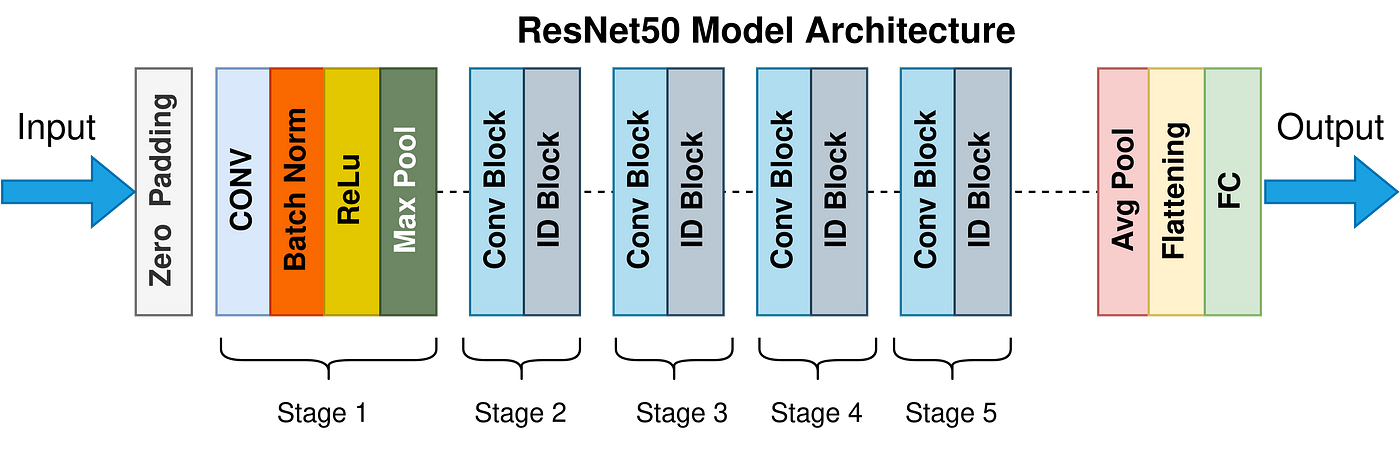

## Import Essential Libraries

In [3]:
# Regular Libraries Imports
from utils import *
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras_tuner as kt
import os
import random
import numpy as np
import cv2
import pandas as pd

# Machine Learning Imports
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt



# Define Constant image size
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
IMAGE_SIZE = (IMG_HEIGHT,IMG_WIDTH)
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)


# 1. Data Exploration

In [4]:
glioma_images = os.listdir(DATASET_FOLDER + "/glioma")
meningioma_images = os.listdir(DATASET_FOLDER + "/meningioma")
no_tumor_images = os.listdir(DATASET_FOLDER + "/notumor")
pituitary_images = os.listdir(DATASET_FOLDER + "/pituitary")

# Check number of images in each category
print(f"Number of images in each category: Glioma: {len(glioma_images)}, Meningioma: {len(meningioma_images)}, No Tumor: {len(no_tumor_images)}, Pituitary: {len(pituitary_images)}")

Number of images in each category: Glioma: 120, Meningioma: 120, No Tumor: 120, Pituitary: 120


*Since there are equal number of data in each class, we can confirm that there will not be any class dominance.*

## Data Sample from each classes

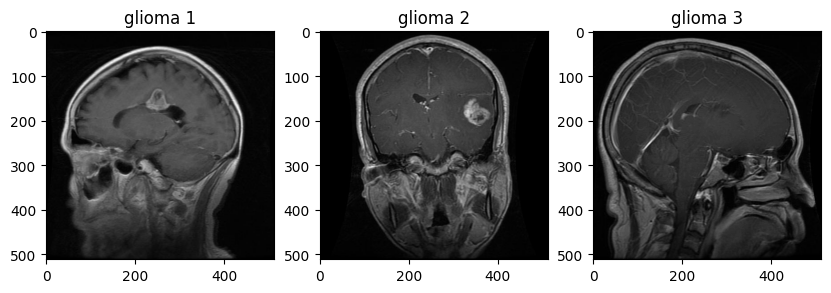

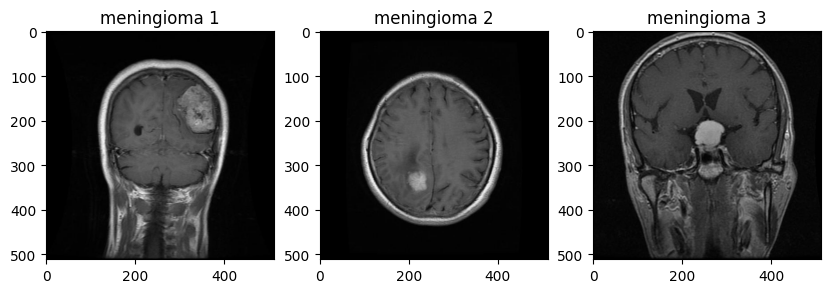

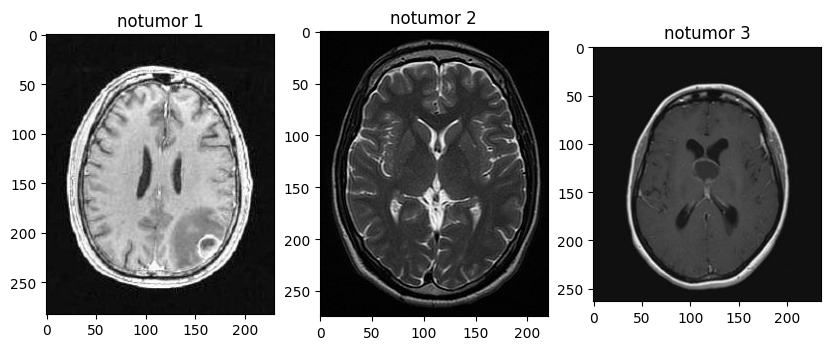

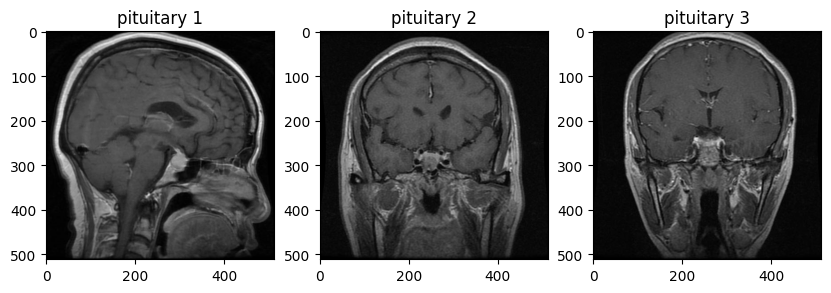

In [5]:
# Function to sample and plot images
def sample_and_plot_images(image_list, category_name, dataset_folder, n=3):
    sampled_images = random.sample(image_list, n)
    plt.figure(figsize=(10, 10))
    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(dataset_folder, category_name, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{category_name} {i+1}")
    plt.show()

# Sample and plot images for each category
sample_and_plot_images(glioma_images, "glioma", DATASET_FOLDER)
sample_and_plot_images(meningioma_images, "meningioma", DATASET_FOLDER)
sample_and_plot_images(no_tumor_images, "notumor", DATASET_FOLDER)
sample_and_plot_images(pituitary_images, "pituitary", DATASET_FOLDER)

*Based on the output of the sample images, the scale of each image are in differnet scale. Therefore, rescaling operation has to be done because it standardizes the range of pixel values, making the training process more stable and helping the model converge faster.*

# 2. Data Preparation

Found 480 files belonging to 4 classes.
Using 384 files for training.
Using 96 files for validation.
Class Names: ['glioma', 'meningioma', 'notumor', 'pituitary']

Training Dataset Preview


2024-07-10 14:20:20.391771: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-07-10 14:20:20.391797: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-10 14:20:20.391801: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-10 14:20:20.391820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-10 14:20:20.391833: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-07-10 14:20:20.571282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


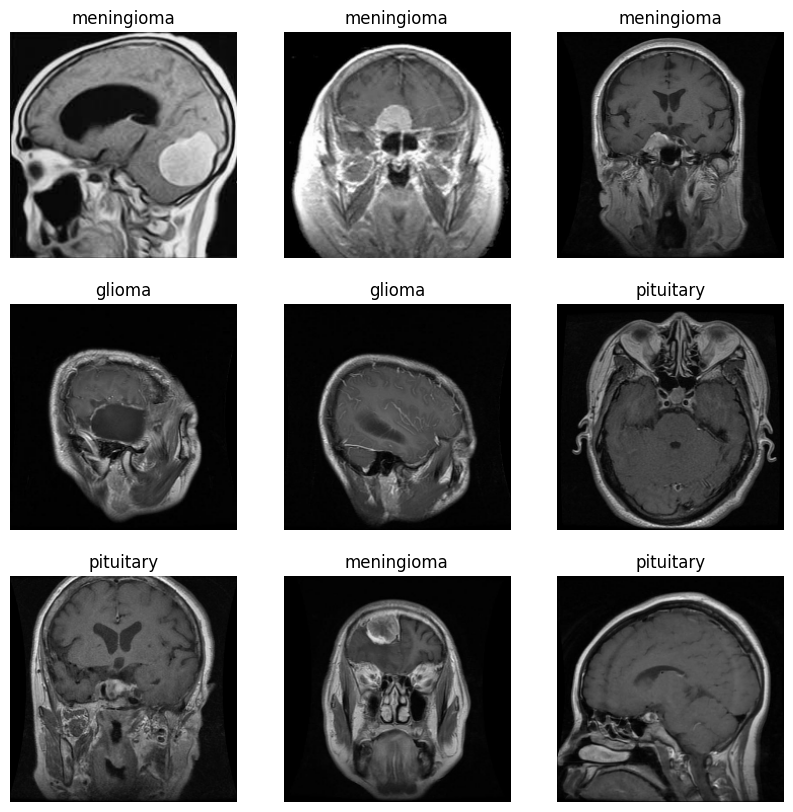

Validation Dataset Preview


2024-07-10 14:20:20.994891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


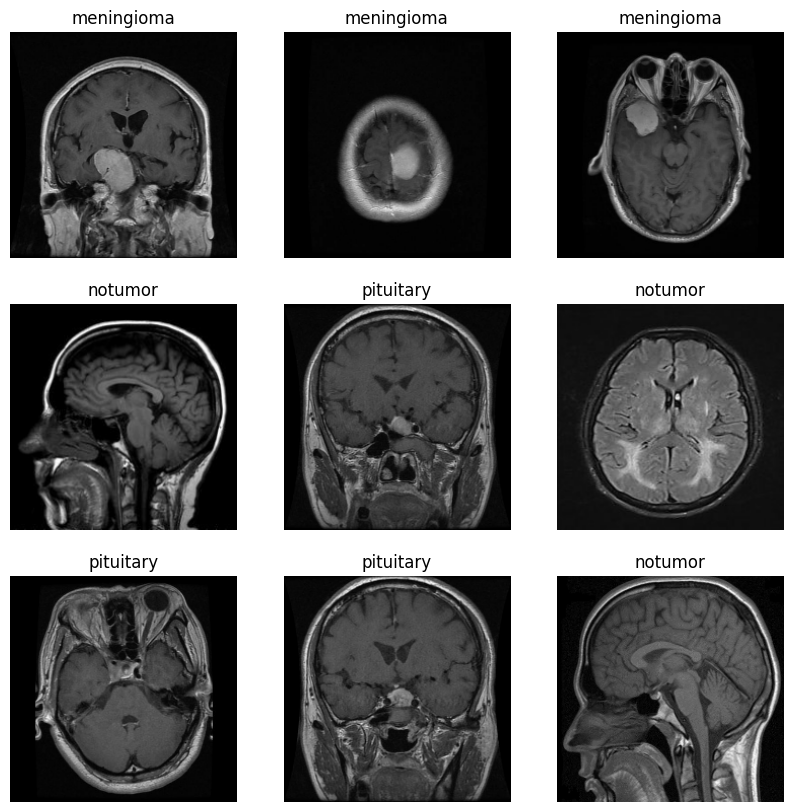

In [6]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    batch_size = BATCH_SIZE,
    image_size = IMAGE_SIZE,
    subset = "both",
    validation_split = 0.2,
    seed = 42,
    shuffle = True)

class_names = train_ds.class_names
print("Class Names:" , class_names)

# Preview datasets
print("\nTraining Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

print("Validation Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3. Model Building - ResNet50V2
*Improved Version of ResNet50v2*

### 3.1 Finding out the most optimal learning rate

In [8]:
# Load ResNet50V2 base model
base_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False

model = tf.keras.Sequential(layers=[
    #Data Augmentation
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    #Base model and Custom Layer
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="softmax") # 4 classes to classify
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

epochs = 50
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch/20))

history = model.fit(train_ds,
                     epochs=epochs,
                     validation_data=val_ds,
                     callbacks=[lr_scheduler]
                     )

Epoch 1/50


2024-07-10 14:20:23.556731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 461ms/step - accuracy: 0.3288 - loss: 1.7984 - val_accuracy: 0.5729 - val_loss: 1.0733 - learning_rate: 1.0000e-04
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.3884 - loss: 1.4572 - val_accuracy: 0.6979 - val_loss: 0.8681 - learning_rate: 1.1220e-04
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.5806 - loss: 1.0846 - val_accuracy: 0.7604 - val_loss: 0.7479 - learning_rate: 1.2589e-04
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.6137 - loss: 0.9848 - val_accuracy: 0.7812 - val_loss: 0.6862 - learning_rate: 1.4125e-04
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - accuracy: 0.6620 - loss: 0.9060 - val_accuracy: 0.7917 - val_loss: 0.6272 - learning_rate: 1.5849e-04
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.6563 - loss: 0.8012 - val_accuracy: 0.7917 - val_loss: 0.5818 - learning_rate: 1.7783e-04
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - accuracy: 0.8183 - l

Text(0, 0.5, 'val_loss')

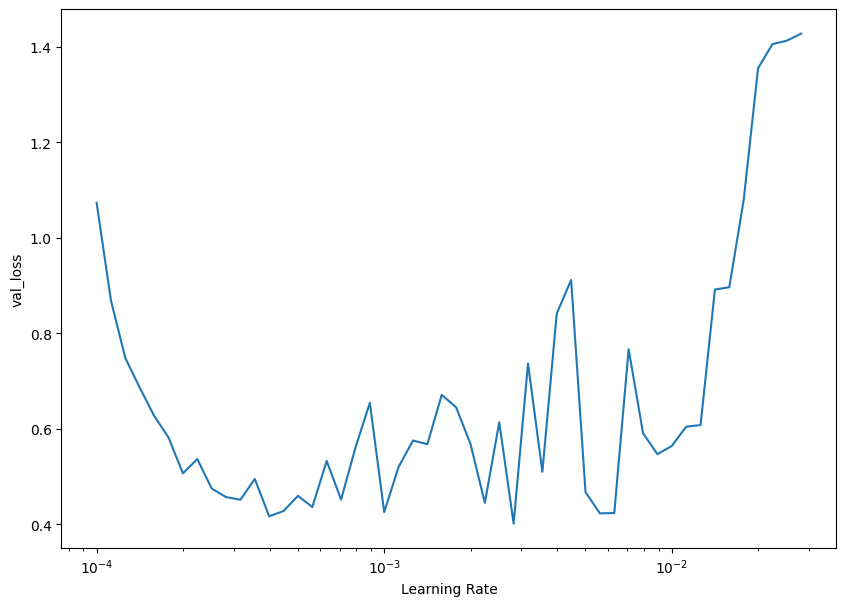

In [9]:
lrs = 1e-4 * (10 ** (np.arange(epochs)/20))
plt.figure(figsize=(10,7))
plt.semilogx(lrs, history.history['val_loss'])
plt.xlabel('Learning Rate')
plt.ylabel('val_loss')

In [10]:
minimum = min(history.history['val_loss'])
index = history.history['val_loss'].index(minimum)
lr = lrs[index]
print("The better learning rate is", lr)

The better learning rate is 0.0028183829312644535


### 3.2 Training the Model with the most optimal learning rate

In [11]:
# Load ResNet50V2 base model
base_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE)
base_model.trainable = False

model = tf.keras.Sequential(layers=[
    tf.keras.layers.Resizing(224, 224),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.25),
    tf.keras.layers.RandomZoom(0.05, 0.05),
    tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation="softmax")
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate = lr),
               metrics=["accuracy"])

epochs = 50

history = model.fit(train_ds,
                     epochs=epochs,
                     validation_data=val_ds
                     )

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 566ms/step - accuracy: 0.4244 - loss: 3.1214 - val_accuracy: 0.6354 - val_loss: 0.8416
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.5971 - loss: 1.3872 - val_accuracy: 0.7292 - val_loss: 0.6000
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 237ms/step - accuracy: 0.6412 - loss: 0.9023 - val_accuracy: 0.7396 - val_loss: 0.6464
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.7645 - loss: 0.7004 - val_accuracy: 0.7292 - val_loss: 0.5772
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 222ms/step - accuracy: 0.7236 - loss: 0.7341 - val_accuracy: 0.7500 - val_loss: 0.5756
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step - accuracy: 0.7558 - loss: 0.5864 - val_accuracy: 0.7917 - val_loss: 0.5030
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - accuracy: 0.7813 - loss: 0.4923 - val_accuracy: 0.8542 - val_loss: 0.4650
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.8096 - loss: 0.4827 - val_accuracy: 0

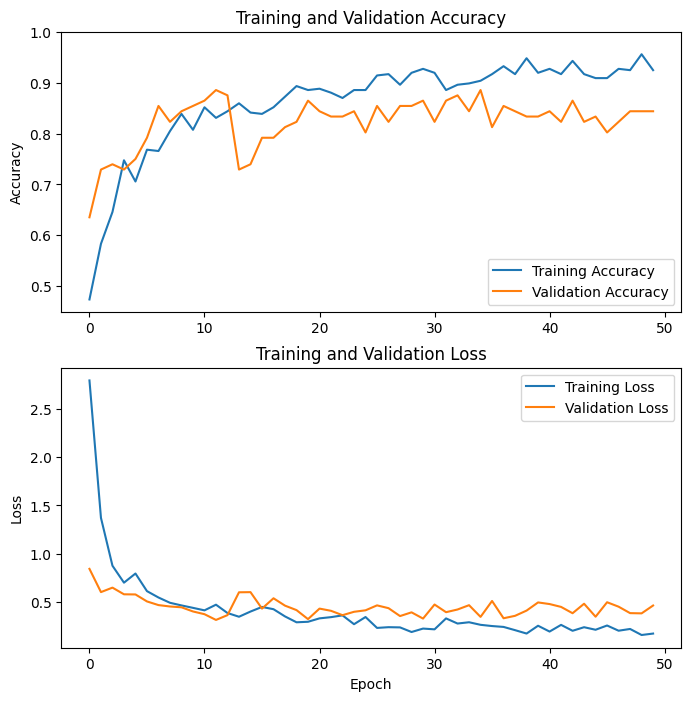

Training Results:
~Accuracy~
Max (best) accuracy: 0.9557291865348816 at epoch 49
Min (worst) accuracy: 0.4739583432674408 at epoch 1
Median accuracy: 0.890625
Mean accuracy: 0.8615625029802323

~Loss~
Min (best) loss: 0.15426252782344818 at epoch 49
Max (worst) loss: 2.799448251724243 at epoch 1
Median loss: 0.28650252521038055
Mean loss: 0.40324103474617007

~Final Training Performance~
Accuracy: 0.9609375, Loss: 0.1143268570303917

Validation Results:
~Accuracy~
Max (best) accuracy: 0.8854166865348816 at epoch 12
Min (worst) accuracy: 0.6354166865348816 at epoch 1
Median accuracy: 0.8333333134651184
Mean accuracy: 0.8229166698455811

~Loss~
Min (best) loss: 0.3107742369174957 at epoch 12
Max (worst) loss: 0.8415749669075012 at epoch 1
Median loss: 0.4307849854230881
Mean loss: 0.44649325370788573

~Final Validation Performance~
Accuracy: 0.84375, Loss: 0.460710734128952


In [12]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(val_ds, verbose=0)))

## Model Performance

~Training Metrics~
Accuracy: 0.9609375
Precision: 0.9639566887134627
Recall: 0.9611918150577945
F1 Score: 0.9611632192282893
Matthews Correlation Coefficient (MCC): 0.9488504225669763
Cohen's Kappa: 0.9478794349985975
Hamming Loss: 0.0390625

Confusion Matrix:
 [[98  0  0  0]
 [ 2 84  0 11]
 [ 0  1 89  0]
 [ 0  1  0 98]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      1.00      0.99        98
  meningioma       0.98      0.87      0.92        97
     notumor       1.00      0.99      0.99        90
   pituitary       0.90      0.99      0.94        99

    accuracy                           0.96       384
   macro avg       0.96      0.96      0.96       384
weighted avg       0.96      0.96      0.96       384




2024-07-10 14:25:10.123654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


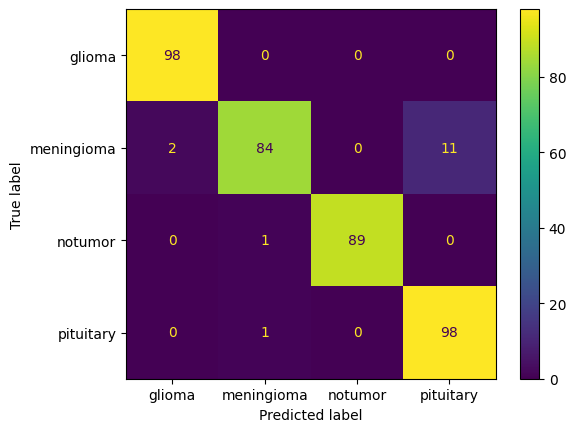

In [13]:
print("~Training Metrics~")
get_model_metrics(train_ds, model, class_names)


~Validation Metrics~
Accuracy: 0.84375
Precision: 0.8437679816990162
Recall: 0.8435300207039338
F1 Score: 0.8284757214841961
Matthews Correlation Coefficient (MCC): 0.7986379274703717
Cohen's Kappa: 0.7908496732026143
Hamming Loss: 0.15625

Confusion Matrix:
 [[22  0  0  0]
 [ 4 12  2  5]
 [ 0  1 27  2]
 [ 0  1  0 20]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.85      1.00      0.92        22
  meningioma       0.86      0.52      0.65        23
     notumor       0.93      0.90      0.92        30
   pituitary       0.74      0.95      0.83        21

    accuracy                           0.84        96
   macro avg       0.84      0.84      0.83        96
weighted avg       0.85      0.84      0.83        96




2024-07-10 14:25:10.750507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


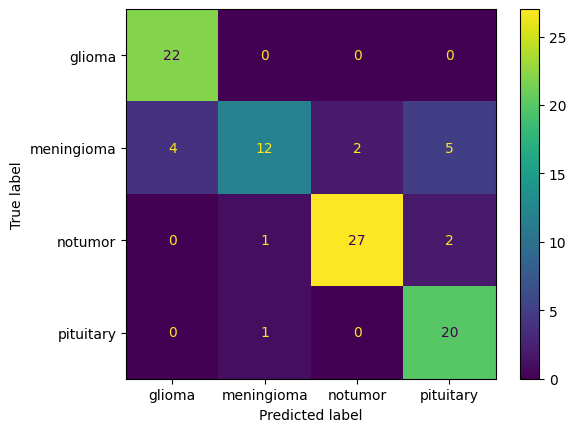

In [14]:
print("\n~Validation Metrics~")
get_model_metrics(val_ds, model, class_names)

## K-Fold Cross-Validation 

In [15]:
from sklearn.model_selection import StratifiedKFold, KFold

""" K-Fold Cross-Validation """
# Load dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []
list_skf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1
    
print("\nStratified K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in skf.split(images, labels):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_skf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

Found 480 files belonging to 4 classes.


2024-07-10 14:25:11.058808: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 0.9609375, Loss: 0.09426955133676529
~Validation Dataset~
Accuracy: 0.8333333134651184, Loss: 0.6222176551818848

Fold Index 1
~Training Dataset~
Accuracy: 0.9713541865348816, Loss: 0.08773544430732727
~Validation Dataset~
Accuracy: 0.96875, Loss: 0.09245847910642624

Fold Index 2
~Training Dataset~
Accuracy: 0.9869791865348816, Loss: 0.06021841987967491
~Validation Dataset~
Accuracy: 0.9583333134651184, Loss: 0.10414651036262512

Fold Index 3
~Training Dataset~
Accuracy: 0.9635416865348816, Loss: 0.11490261554718018
~Validation Dataset~
Accuracy: 0.9166666865348816, Loss: 0.16447557508945465

Fold Index 4
~Training Dataset~
Accuracy: 0.984375, Loss: 0.043225985020399094
~Validation Dataset~
Accuracy: 0.9583333134651184, Loss: 0.11433122307062149


Stratified K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 0.9869791865348816, Loss: 0.03236004710197449
~Validation Dataset~
Accuracy: 0.9583333134651184, L

# Keras Tuner Optimisation

In [16]:
import keras_tuner as kt

def build_model(hp):
    base_model = ResNet50V2(include_top=False, input_shape=INPUT_SHAPE)
    base_model.trainable = False

    model = tf.keras.Sequential([
        tf.keras.layers.Resizing(224, 224),
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.25),
        tf.keras.layers.RandomZoom(0.05, 0.05),
        tf.keras.layers.Rescaling(scale=1./127.5, offset=-1),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(hp.Int('units1', min_value=256, max_value=1024, step=128), activation="relu"),
        tf.keras.layers.Dropout(hp.Float('dropout1', min_value=0.2, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(hp.Int('units2', min_value=128, max_value=512, step=64), activation="relu"),
        tf.keras.layers.Dropout(hp.Float('dropout2', min_value=0.2, max_value=0.5, step=0.1)),
        tf.keras.layers.Dense(4, activation="softmax")
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    )
    
    return model


In [34]:
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='resnet50v2_classification',
    project_name='brain_tumor_tuning'
)

Reloading Tuner from resnet50v2_classification/brain_tumor_tuning/tuner0.json


In [35]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of units in the first dense layer is {best_hps.get('units1')}.
The optimal number of units in the second dense layer is {best_hps.get('units2')}.
The optimal learning rate is {best_hps.get('learning_rate')}.
The optimal dropout rate for the first dropout layer is {best_hps.get('dropout1')}.
The optimal dropout rate for the second dropout layer is {best_hps.get('dropout2')}.
""")


The optimal number of units in the first dense layer is 768.
The optimal number of units in the second dense layer is 256.
The optimal learning rate is 0.0001.
The optimal dropout rate for the first dropout layer is 0.4.
The optimal dropout rate for the second dropout layer is 0.4.



Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.2310 - loss: 1.9360 - val_accuracy: 0.4375 - val_loss: 1.2341
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 596ms/step - accuracy: 0.4324 - loss: 1.2972 - val_accuracy: 0.6146 - val_loss: 0.9570
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 488ms/step - accuracy: 0.5659 - loss: 0.9922 - val_accuracy: 0.7188 - val_loss: 0.8233
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 402ms/step - accuracy: 0.5849 - loss: 0.9592 - val_accuracy: 0.7292 - val_loss: 0.7529
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.7065 - loss: 0.7537 - val_accuracy: 0.7708 - val_loss: 0.7067
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 301ms/step - accuracy: 0.7689 - loss: 0.6673 - val_accuracy: 0.7604 - val_loss: 0.6659
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 257ms/step - accuracy: 0.7351 - loss: 0.6565 - val_accuracy: 0.7917 - val_loss: 0.6119
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.7631 - loss: 0.5931 - val_accuracy: 0.78

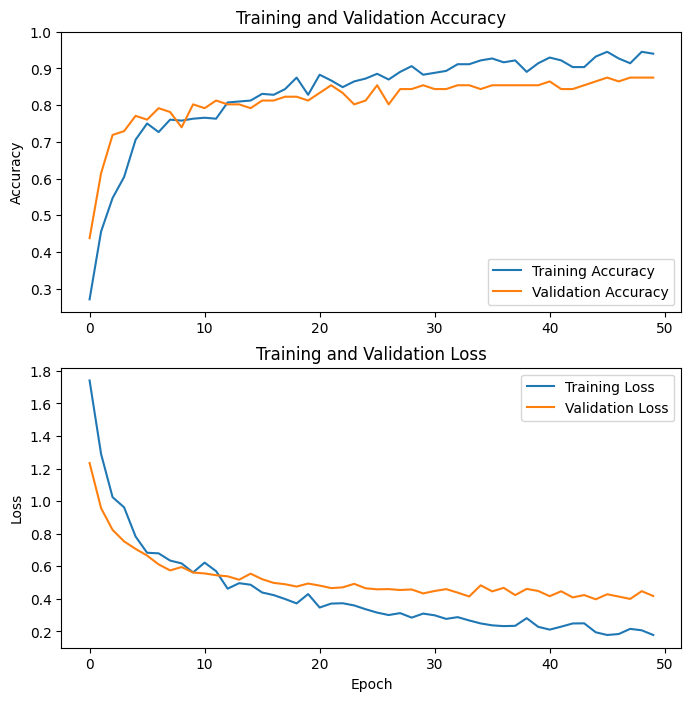

Training Results:
~Accuracy~
Max (best) accuracy: 0.9453125 at epoch 46
Min (worst) accuracy: 0.2708333432674408 at epoch 1
Median accuracy: 0.87890625
Mean accuracy: 0.8327083325386048

~Loss~
Min (best) loss: 0.17816418409347534 at epoch 46
Max (worst) loss: 1.7411643266677856 at epoch 1
Median loss: 0.3260089308023453
Mean loss: 0.43362812012434004

~Final Training Performance~
Accuracy: 0.9635416865348816, Loss: 0.12592153251171112

Validation Results:
~Accuracy~
Max (best) accuracy: 0.875 at epoch 46
Min (worst) accuracy: 0.4375 at epoch 1
Median accuracy: 0.8385416567325592
Mean accuracy: 0.8141666686534882

~Loss~
Min (best) loss: 0.3973200023174286 at epoch 45
Max (worst) loss: 1.2341145277023315 at epoch 1
Median loss: 0.46693025529384613
Mean loss: 0.5200989311933517

~Final Validation Performance~
Accuracy: 0.875, Loss: 0.417709618806839


In [36]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_ds, epochs=50, validation_data=val_ds)

# Visualize model performance
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(val_ds, verbose=0)))


~Training Metrics~
Accuracy: 0.9947916666666666
Precision: 0.9948651780071625
Recall: 0.9947916666666666
F1 Score: 0.9947877415623823
Matthews Correlation Coefficient (MCC): 0.9930808059899146
Cohen's Kappa: 0.9930538597205264
Hamming Loss: 0.005208333333333333

Confusion Matrix:
 [[100   0   0   0]
 [  1  94   0   1]
 [  0   0  95   0]
 [  0   0   0  93]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      1.00      1.00       100
  meningioma       1.00      0.98      0.99        96
     notumor       1.00      1.00      1.00        95
   pituitary       0.99      1.00      0.99        93

    accuracy                           0.99       384
   macro avg       0.99      0.99      0.99       384
weighted avg       0.99      0.99      0.99       384




2024-07-10 16:17:14.178369: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


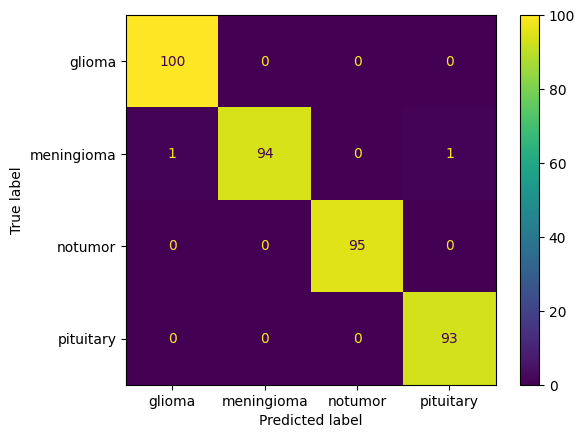

In [41]:
print("\n~Training Metrics~")
get_model_metrics(train_ds, model, class_names)


~Validation Metrics~
Accuracy: 0.875
Precision: 0.8760464669738863
Recall: 0.872824074074074
F1 Score: 0.8715258218892726
Matthews Correlation Coefficient (MCC): 0.8346014323164476
Cohen's Kappa: 0.8325337985172263
Hamming Loss: 0.125

Confusion Matrix:
 [[18  2  0  0]
 [ 2 17  0  5]
 [ 1  1 23  0]
 [ 0  0  1 26]]

Classification Report:
               precision    recall  f1-score   support

      glioma       0.86      0.90      0.88        20
  meningioma       0.85      0.71      0.77        24
     notumor       0.96      0.92      0.94        25
   pituitary       0.84      0.96      0.90        27

    accuracy                           0.88        96
   macro avg       0.88      0.87      0.87        96
weighted avg       0.88      0.88      0.87        96




2024-07-10 16:05:15.084068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


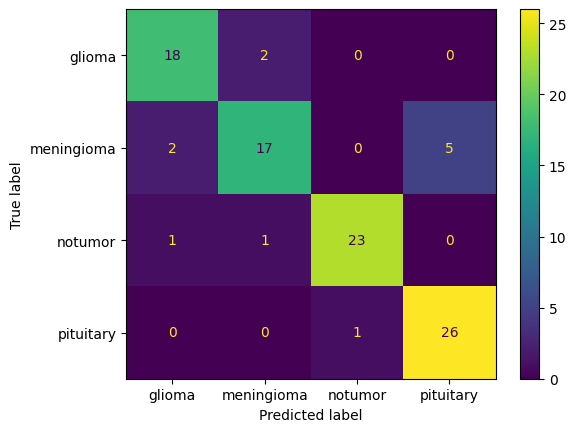

In [38]:
print("\n~Validation Metrics~")
get_model_metrics(val_ds, model, class_names)

# Model Evaluation

### K-Fold Cross-Validation 

In [42]:
from sklearn.model_selection import StratifiedKFold, KFold

""" K-Fold Cross-Validation """
# Load dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []
list_skf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1
    
print("\nStratified K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in skf.split(images, labels):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=64, verbose=0)
    
    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)
    
    # Save results
    list_skf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})
    
    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")
    
    # Increment fold number
    fold_no += 1

Found 480 files belonging to 4 classes.


2024-07-10 16:26:36.310092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 0.9895833134651184, Loss: 0.02694704942405224
~Validation Dataset~
Accuracy: 0.9791666865348816, Loss: 0.05991409346461296

Fold Index 1
~Training Dataset~
Accuracy: 0.9947916865348816, Loss: 0.01091271173208952
~Validation Dataset~
Accuracy: 0.9895833134651184, Loss: 0.023849211633205414

Fold Index 2
~Training Dataset~
Accuracy: 0.9973958134651184, Loss: 0.00783522892743349
~Validation Dataset~
Accuracy: 1.0, Loss: 0.014516175724565983

Fold Index 3
~Training Dataset~
Accuracy: 0.9921875, Loss: 0.02571340836584568
~Validation Dataset~
Accuracy: 0.9791666865348816, Loss: 0.03724387288093567

Fold Index 4
~Training Dataset~
Accuracy: 0.9973958134651184, Loss: 0.007353549357503653
~Validation Dataset~
Accuracy: 1.0, Loss: 0.006912980228662491


Stratified K-Fold Cross-Validation
Fold Index 0
~Training Dataset~
Accuracy: 0.9947916865348816, Loss: 0.008604451082646847
~Validation Dataset~
Accuracy: 0.9895833134651184, Loss:

In [43]:
import json
print("K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_kf_results]
train_losses = [result['train_loss'] for result in list_kf_results]
val_accuracies = [result['val_accuracy'] for result in list_kf_results]
val_losses = [result['val_loss'] for result in list_kf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

print("\nStratified K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_skf_results]
train_losses = [result['train_loss'] for result in list_skf_results]
val_accuracies = [result['val_accuracy'] for result in list_skf_results]
val_losses = [result['val_loss'] for result in list_skf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 0.9973958134651184,
        "min": 0.9895833134651184,
        "median": 0.9947916865348816,
        "mean": 0.9942708253860474
    },
    "Training Loss": {
        "max": 0.02694704942405224,
        "min": 0.007353549357503653,
        "median": 0.01091271173208952,
        "mean": 0.015752389561384916
    },
    "Validation Accuracy": {
        "max": 1.0,
        "min": 0.9791666865348816,
        "median": 0.9895833134651184,
        "mean": 0.9895833373069763
    },
    "Validation Loss": {
        "max": 0.05991409346461296,
        "min": 0.006912980228662491,
        "median": 0.023849211633205414,
        "mean": 0.028487266786396504
    }
}

Stratified K-Fold Cross-Validation Results
{
    "Training Accuracy": {
        "max": 1.0,
        "min": 0.9947916865348816,
        "median": 1.0,
        "mean": 0.9989583373069764
    },
    "Training Loss": {
        "max": 0.008604451082646847,
        "m